# Introdução

Este é a terceira e última parte do meu projeto de Processamento de Linguagem Natural para o treinamento de um modelo capaz de fazer previsão em comentários de restaurantes, podendo eles serem positivos ou negativos.

Após finalizar a limpeza, preparação e pré-processamento dos dados nas partes anteriores do projeto, iremos prosseguir para a reta final.



**OBJETIVOS**

**1.** Aplicar vetorização nos tokens

**2.** Divisão dos dados em conjuntos de treinamento e teste

**3.** Implementação de técnicas para lidar com o desbalanceamento

**4.** Treinamento e avaliação do modelo

**5.** Testar com novas amostras

Ao andentrar no mundo de Machine Learning... de começo... pode parecer algo bastante complicado e difícil de entender. Mas no decorrer do meu projeto, irei desmistificar um pouco meu código para que fique claro todas as minhas ações.

## Importando bibliotecas

In [18]:
import numpy as np
import pandas as pd
import pickle

# Vetorização
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api

# Divisão - Treinamento - Avaliação
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter

# Pré-processamento de texto
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import unicodedata
import nltk
import re

# Plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Ocultando mensagens do sistema
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Checando dependências...
WordNetLemmatizer()
nltk.download('stopwords')
stopwords.words('english')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thiago\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thiago\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thiago\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Thiago\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Preparando funções

In [21]:
def get_keywords(tfidf_vector, vocab, top_n=5):
  """
  Identifica as top N palavras-chave de um texto com base nos valores TF-IDF.
  Retorna um dicionário com as palavras e seus pesos TF-IDF.
  """
  top_indices = np.argsort(tfidf_vector.toarray()[0])[::-1][:top_n]
  return {vocab[i]: tfidf_vector[0, i] for i in top_indices}

In [22]:
def vectorize_review(review, model):
    """
    Converte um comentário em um vetor usando word embeddings.
    """
    words = word_tokenize(review)
    words = [word for word in words if word in model]
    if not words: 
        return np.zeros(model.vector_size) 
    try:
        word_vectors = [model[word] for word in words] 
        review_vector = np.mean(word_vectors, axis=0) 
        return review_vector
    except Exception as e:
        print(f"Erro ao vetorizar review: {e}")
        return np.zeros(model.vector_size)

In [24]:
# Mesma função de pre-processamento utilizado na etapa anterior deste projeto
# Será aplicado nas novas amostras para testes
def text_preprocessing(text):
    """
    Preprocessa um texto removendo caracteres especiais,
    removendo números, stop words e lematizando.

    Args:
        text (str): O texto a ser pre-processado.

    Returns:
        str: O texto pre-processado.  Retorna uma string vazia em caso de erro.
    """
    try:
        text = unicodedata.normalize('NFD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        tokens = word_tokenize(text)

        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        lemmatizer = WordNetLemmatizer()
        tokens_sl = [lemmatizer.lemmatize(token) for token in tokens]

        return " ".join(tokens_sl)
    except Exception as e:
        print(f"Erro no pre-processamento: {e}")
        return ""

## Preparando os dados

In [26]:
data = pd.read_csv('restaurante_preprocessado.csv')
df = pd.DataFrame(data)
print(f"\n↳ Quantidade de linhas: {df.shape[0]}")
print(f"↳ Quantidade de colunas: {df.shape[1]}\n")
df.head()


↳ Quantidade de linhas: 1740454
↳ Quantidade de colunas: 3



,ratings,sentiments,reviews
0,1,Negative,ok place terrible came bc weve always walked a...
1,1,Negative,always enjoyed averagetooutstanding tiramisu e...
2,1,Negative,second visit disapointed time go againa lady s...
3,1,Negative,eat tourist trap worst food ever many great pl...
4,1,Negative,went first night bcn sadly mistake ordered jug...


In [31]:
# Analisando se há valores ausentes
df.isnull().sum()

ratings       0
sentiments    0
reviews       5
dtype: int64

Alguns dados passaram despercebidos durante a limpeza nas etapas anteriores do projeto. Com apenas essas amostras nulas seriam o suficiente para travar o treinamento do medelo. Então, vamos removê-las.

In [33]:
df = df.dropna()

## Vetorização inicial com TF-IDF




Para que uma máquina possa entender as `reviews` , teremos que deixar de lado nosso alfabeto e transformar cada palavra em números. Isso facilita a compreensão para a máquina e traz uma melhor eficácia para o seu treinamento.

Deste modo, irei utilizar duas técnicas de vetorização:
- `TF-IDF` para conversão das palavras em números, acrescentando um peso maior nas palavras que são importantes em cada frase. Irei utilizar essa vetorização apenas para apresentar as palavras-chaves de algumas frases.

- `Word Embedinggs` com o modelo para captar as relações semânticas das palavras, isso ajuda a manter a ordem das palavras e a coesão dos textos. Será excelente para o utilizar no treinamento do modelo.

In [41]:
# Aplicando a vetorização TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['reviews'])

vocab = tfidf_vectorizer.get_feature_names_out()

Com a vetorização inicial concluída, podemos analisar as palavras mais importantes em cada frase.

A seguir, irei apresentar as 15 palavras-chaves da primeira review em uma nuvem de palavras.

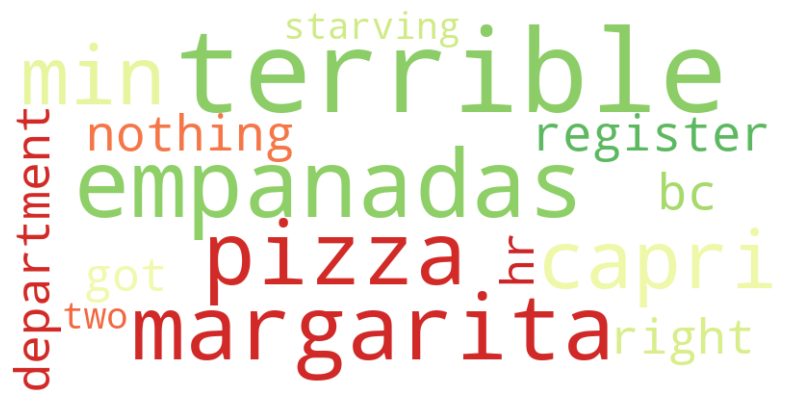

In [43]:
comentario = df['reviews'][0]
tfidf_vector = tfidf_matrix[0]
keywords_dict = get_keywords(tfidf_vector, vocab, top_n=15)

# Gerando uma nuvem das keywords
wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=120,
    random_state=42,
    width=800,
    height=400,
    colormap='RdYlGn'
).generate_from_frequencies(keywords_dict)

# Plotando...
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

_Apenas com as palavras chaves, podemos notar que o cliente não ficou muito satisfeito com seu pedido._

## Vetorização com Word Embeddings

Visando capturar as nuances semânticas e o contexto das avaliações, este projeto empregará a técnica de word embeddings para vetorização dos comentários. Utilizaremos o modelo pré-treinado GloVe (especificamente, o modelo `glove-twitter-50` disponível no Gensim), que além de gerar vetores de 50 dimensões, é especialmente adequado para lidar com a linguagem informal presente em redes sociais.

In [47]:
# Carregando a api...
word2vec_model = api.load("glove-twitter-50")

[==================================================] 100.0% 199.5/199.5MB downloaded


In [48]:
df['review_vector'] = df['reviews'].apply(lambda review: vectorize_review(review, word2vec_model))
df.head()

,ratings,sentiments,reviews,review_vector
0,1,Negative,ok place terrible came bc weve always walked a...,"[0.10202537, 0.2507086, 0.1246914, -0.2035124,..."
1,1,Negative,always enjoyed averagetooutstanding tiramisu e...,"[-0.098624356, 0.015999028, 0.10417469, 0.1693..."
2,1,Negative,second visit disapointed time go againa lady s...,"[0.23322089, 0.3702884, 0.16886976, -0.1241259..."
3,1,Negative,eat tourist trap worst food ever many great pl...,"[0.25848934, 0.3469383, -0.08933615, -0.221015..."
4,1,Negative,went first night bcn sadly mistake ordered jug...,"[-0.12431122, 0.067870215, 0.31404188, -0.0629..."


Por fim, vamos finalizar nossa vetorização preparando o `texto` e o `rotulo` para começarmos o nosso processo de treinamento.

In [50]:
texto = np.stack(df['review_vector'].values)
rotulo = df['sentiments']

## Corrigir dados desbalanceados

Uma coisa muito interessante sobre Machine Learning é que o seu objetivo principal não é simplesmente "memorizar" os dados que foram usados para treiná-lo. Em vez disso, o nosso modelo aprende padrões e relações nos dados que podem ser generalizados para novos dados que ele nunca viu antes.

Deste modo, nosso próximo passo é dividir todos os dados em duas partes:
  - A primeira parte terá uma quantidade maior, com **80%** da quantidade total. Esses dados serão usados para **treinar** o modelo _(imagine como um aluno estudando para uma prova)_.

  - A segunda parte, obviamente bem menor com **20%** dos dados, será utilizado para **testar** o conhecimento do nosso modelo _(a prova que será realizada pelo aluno, usando o conteúdo estudado)._
      - Aqui será definido no parâmetro do código abaixo com `teste_size=0.2` , ou seja, os 20%.

In [53]:
# Divisão dos dados
texto_treino, texto_teste, rotulo_treino, rotulo_teste = train_test_split(texto, rotulo, test_size=0.2, random_state=42)

A seguir devemos aplicar uma técnica de extrema importância.

Conforme demonstrado na análise do gráfico abaixo, o conjunto de dados apresenta um desbalanceamento significativo, com um número maior de avaliações positivas em comparação com as negativas. Nesse sentido, a fim de mitigar o risco de viés e garantir um desempenho adequado em ambas as classes, é fundamental aplicar uma técnica de balanceamento que equilibre a representatividade dos sentimentos positivo e negativo durante o treinamento do modelo.

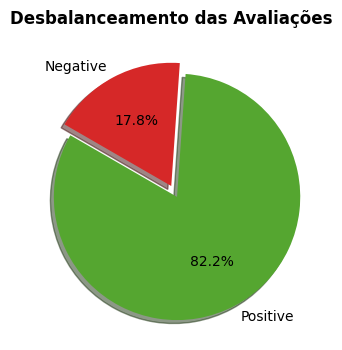

In [55]:
# Preparando dados para plotagem
df_sentiment = df.groupby('sentiments')['ratings'].count().reset_index(name='count')
positive_count = df_sentiment.loc[df_sentiment['sentiments'] == 'Positive', 'count'].values[0]
negative_count = df_sentiment.loc[df_sentiment['sentiments'] == 'Negative', 'count'].values[0]

sizes = [positive_count, negative_count]
labels = ['Positive', 'Negative']
colors =['#55a630', '#d62828']

# Plotando...
plt.figure(figsize=(5,4))
plt.pie(sizes,
        labels=labels,
        colors=colors,
        explode=(0.1,0),
        autopct='%1.1f%%',
        shadow=True,
        startangle=150)

plt.title('Desbalanceamento das Avaliações', fontweight='bold')
plt.show()

Deste modo, iremos aplicar duas técnicas para lidar com esse problema e balancear os dados:
- `Oversampling` para aumentar o número de amostras da classe minoritária. Minha intenção aqui será apenas para duplicar a quantidade de comentários negativos, visando equilibrar uma parte da distribuição dos dados.
  
- `Undersampling` para reduzir o número de amostras de classe majoritária (dados com comentários posistivos), removendo aleatoriamente algumas amostras para igualar os dados.

### Oversampling

In [58]:
# Label Encoding irá converter 'Positive' e 'Negative' para 0 e 1
label_encoder = LabelEncoder()
rotulo_treino_encoded = label_encoder.fit_transform(rotulo_treino)

# Contagem para marcação inicial
contador = Counter(rotulo_treino_encoded)
print('↳ Antes do oversampling: ', contador)

# Aplicando oversampling...
estrategia_balanceamento = {0: int(contador[1]*0.6)}  
oversampler = RandomOverSampler(sampling_strategy=estrategia_balanceamento)
texto_treino_oversampled, rotulo_treino_oversampled = oversampler.fit_resample(texto_treino, rotulo_treino_encoded)

# Contagem para marcação final
contador = Counter(rotulo_treino_oversampled)
print('\n↳ Depois do oversampling: ', contador)

# Aqui vamos reverter a codificação feita no começo
rotulo_treino_oversampled = label_encoder.inverse_transform(rotulo_treino_oversampled)

↳ Antes do oversampling:  Counter({1: 1144650, 0: 247709})

↳ Depois do oversampling:  Counter({1: 1144650, 0: 686790})


### Undersampling

In [60]:
# Aplicando o undersampling...
undersampler = RandomUnderSampler(random_state=42)
texto_treino_balanceado, rotulo_treino_balanceado = undersampler.fit_resample(texto_treino_oversampled, rotulo_treino_oversampled)

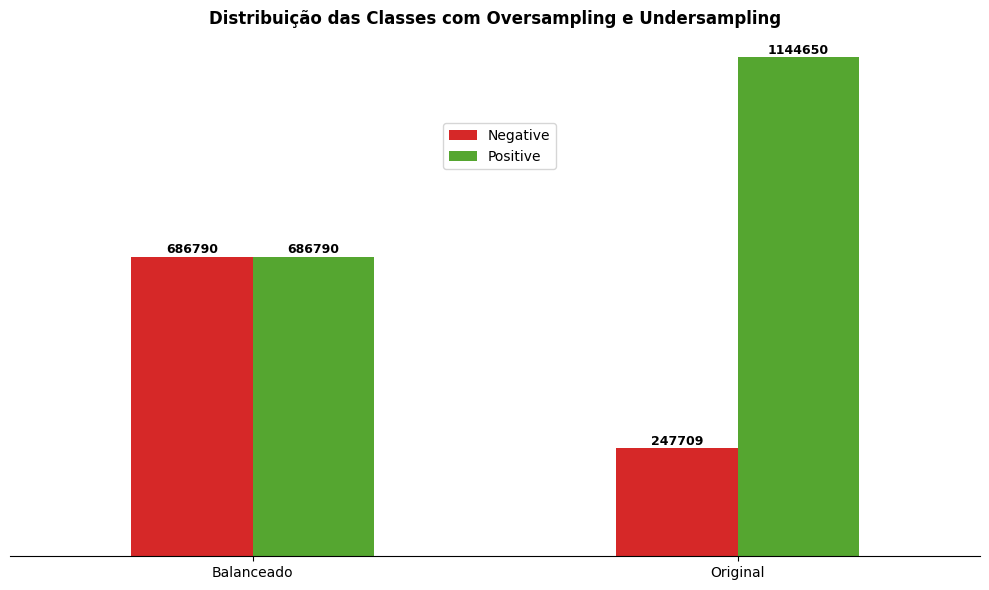

In [61]:
# Preparando os dados..
df_antes = pd.DataFrame({'classe': rotulo_treino, 'tipo': 'Original'})
df_depois = pd.DataFrame({'classe': rotulo_treino_balanceado, 'tipo': 'Balanceado'})
df_completo = pd.concat([df_antes, df_depois])

contagens = df_completo.groupby(['tipo', 'classe']).size().unstack(fill_value=0)

# Plotando o gráfico de barras
ax = contagens.plot(kind='bar',
                    figsize=(10, 6),
                    color=colors[::-1],
                    rot=0)

for i in ax.patches:
    ax.annotate(f'{i.get_height():.0f}',
                (i.get_x() + i.get_width() / 2., i.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=9, fontweight='bold')

ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title('Distribuição das Classes com Oversampling e Undersampling', fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='', bbox_to_anchor=(0.57, 0.84))
plt.tight_layout()
plt.show()

## Treinamento e Avaliação

Com os dados vetorizados, dividos e balanceados, estamos prontos para seguir com o aprendizado de máquina. Para isso, irei utilizar a `LogisticRegression` para classificar e treinar um modelo capaz de avaliar novos comentários e os rotular como `Positive` ou `Negative`.

Para a avaliação, serão utilizados as métricas:
- Precisão: Mede a exatidão das previsões positivas, indicando a proporção de comentários classificados como 'Positive' que realmente o são.

- Recall: Mede a capacidade do modelo de encontrar todos os comentários positivos, indicando a proporção de comentários 'Positive' reais que foram corretamente identificados.

- F1-score: Combina precisão e recall em uma única métrica, útil para avaliar o desempenho geral do modelo, considerando tanto a exatidão quanto a capacidade de encontrar todos os casos positivos.

In [63]:
print("↳ Texto para treino:", texto_treino_oversampled.shape)
print("↳ Texto para teste:", texto_teste.shape)

↳ Texto para treino: (1831440, 50)
↳ Texto para teste: (348090, 50)


In [75]:
# Treinamento do modelo com Regressão Logística

modelo = LogisticRegression()
modelo.fit(texto_treino_oversampled, rotulo_treino_oversampled)

previsoes = modelo.predict(texto_teste)

In [77]:
# Salvando o modelo para aplicação
with open("modelo_treinado.pkl", "wb") as f:
    pickle.dump(modelo, f)
print("Modelo treinado salvo em 'modelo_treinado.pkl'")

Modelo treinado salvo em 'modelo_treinado.pkl'


In [80]:
# Avaliação no conjunto de teste
print(f"➥ Precisão: {(precision_score(rotulo_teste, previsoes, average='weighted') * 100):.1f}%")
print(f"➥ Recall: {(recall_score(rotulo_teste, previsoes, average='weighted') * 100):.1f}%")
print(f"➥ Recall: {(f1_score(rotulo_teste, previsoes, average='weighted') * 100):.1f}%")

➥ Precisão: 87.8%
➥ Recall: 85.8%
➥ Recall: 86.5%


As métricas estão com resultados muito bons, em aproximadamente `85%`. Mas vamos estudar isso um pouco mais afundo e analisar essa avaliação com mais atenção.

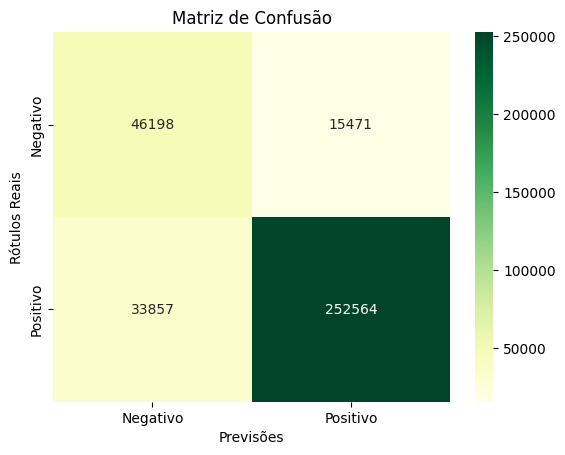

In [82]:
# Grafico para matriz de confusão
matriz_confusao = confusion_matrix(rotulo_teste, previsoes)
nomes_classes = ['Negativo', 'Positivo']

sns.heatmap(matriz_confusao,
            annot=True,
            fmt='d',
            cmap='YlGn',
            xticklabels=nomes_classes,
            yticklabels=nomes_classes)

plt.title('Matriz de Confusão')
plt.xlabel('Previsões')
plt.ylabel('Rótulos Reais')
plt.show()

A matriz de confusão apresenta o desempenho do modelo de análise de sentimentos na classificação de comentários como "Positivo" ou "Negativo". Observando os valores:

- **Verdadeiros Negativos (TN):** 46216 comentários negativos foram corretamente classificados como negativos.

- **Falsos Positivos (FP):** 15453 comentários negativos foram incorretamente classificados como positivos.

- **Falsos Negativos (FN):** 33957 comentários positivos foram incorretamente classificados como negativos.

- **Verdadeiros Positivos (TP):** 252464 comentários positivos foram corretamente classificados como positivos.

O modelo demonstra um desempenho significativamente melhor na identificação de comentários positivos (TP = 252464) do que na identificação de comentários negativos (TN = 46216). Isso pode ser observado pela diferença marcante nos valores de verdadeiros positivos e verdadeiros negativos.

O número relativamente alto de falsos negativos (FN = 33957) indica que o modelo está perdendo uma quantidade considerável de comentários positivos, classificando-os incorretamente como negativos. Além disso, o número de falsos positivos (FP = 15453) sugere que alguns comentários negativos estão sendo erroneamente identificados como positivos.

Oversampling e undersampling alteram a distribuição dos dados de treinamento, mas não garantem uma representação perfeita das classes no conjunto de teste. O conjunto de teste reflete a distribuição real dos dados, que ainda pode ser desbalanceada.

In [84]:
print("\nRelatório de Classificação:\n\n", classification_report(rotulo_teste, previsoes, zero_division=0))


Relatório de Classificação:

               precision    recall  f1-score   support

    Negative       0.58      0.75      0.65     61669
    Positive       0.94      0.88      0.91    286421

    accuracy                           0.86    348090
   macro avg       0.76      0.82      0.78    348090
weighted avg       0.88      0.86      0.87    348090



O relatório de classificação revela um desempenho promissor do modelo, com altas pontuações de precisão e recall para o rótulo `Positive`. No entanto, o rótulo `Negative` apresenta uma precisão consideravelmente menor, indicando uma área para futuras otimizações. Esforços adicionais devem se concentrar em refinar a capacidade do modelo de identificar e classificar corretamente os comentários negativos, possivelmente explorando técnicas mais avançadas de balanceamento de classes ou ajustando os parâmetros do modelo para melhorar seu desempenho nesta classe específica.

## Testando Modelo

A seguir, iremos finalizar este projeto testando o modelo com novas amostras e avaliar sua eficácia em prever a rotulagem desses novos comentários. Para isso, separei três conjuntos de reviews:

- Frases geradas com inteligência artificial.
- Um restaurante brasileiro que possui muitas reviews de estrangeiros, no TripAdvisor.
- Uma pizzaria de Paris com várias reviews em inglês, no TripAdvidor.

In [88]:
# Teste com frases gerados com IA
reviews = [
    "Best pizza I've ever had! Perfect crust, fresh ingredients, and impeccable service. Highly recommend!",
    "Extremely disappointed with the food quality. I ordered pasta that was cold and tasteless. I'll never go back!",
    "The food is excellent, but the price is very high. Prepare your wallet!",
    "The waiter was inattentive, the food took forever to arrive, and it was still wrong. I ordered a medium-rare steak and it came rare. A horrible experience.",
    "Delicious food and fair price. I recommend it!",
    "The restaurant is very noisy and the tables are too close together. Impossible to have a peaceful conversation.",
    "The service was efficient and friendly, but the food didn't impress me. I expected more.",
    "The red berry cheesecake is simply sensational! It's worth the visit just for that.",
]

novos_coments_preprocessados = [text_preprocessing(review) for review in reviews]
novos_coments_vetorizados = [vectorize_review(review, word2vec_model) for review in novos_coments_preprocessados]
novos_coments_previsao = modelo.predict(novos_coments_vetorizados)

for review, prediction in zip(reviews, novos_coments_previsao):
    print(f"➫ Comentário: {review}\n   Previsão: {prediction}\n")

➫ Comentário: Best pizza I've ever had! Perfect crust, fresh ingredients, and impeccable service. Highly recommend!
   Previsão: Positive

➫ Comentário: Extremely disappointed with the food quality. I ordered pasta that was cold and tasteless. I'll never go back!
   Previsão: Negative

➫ Comentário: The food is excellent, but the price is very high. Prepare your wallet!
   Previsão: Negative

➫ Comentário: The waiter was inattentive, the food took forever to arrive, and it was still wrong. I ordered a medium-rare steak and it came rare. A horrible experience.
   Previsão: Negative

➫ Comentário: Delicious food and fair price. I recommend it!
   Previsão: Positive

➫ Comentário: The restaurant is very noisy and the tables are too close together. Impossible to have a peaceful conversation.
   Previsão: Negative

➫ Comentário: The service was efficient and friendly, but the food didn't impress me. I expected more.
   Previsão: Negative

➫ Comentário: The red berry cheesecake is simply sen

**Testando modelo em reviews de restaurantes do TripAdvisor**

In [90]:
# Comentários de um restaurante no Brasil
reviews = [
    "The service is great and the food is delicious. Very elaborated tasty desserts too! It is a great place to enjoy a good lunch or dinner. We also like to celebrate special occasions at Piselli",
    "Completely tasteless food. Nothing to do with Italian food. A lot of show, but nothing of quality in the things served. I ordered ravioli with lamb and it had less of a raw potato flavor. Typical Brasilia restaurant: expensive and lacking in content. Good service, nonetheless.",
    "The environment is very nice, good service but the food left much to be desired. My dish was Ravioli di Brie e Pera, I finished the dish but I didn't like it and my friend ordered a Pesce i Zuca, which she couldn't finish, because the fish was poorly cooked and the combination with the bar chestnut also didn't like and the pumpkin puré was tasteless. I tried her dish and found it bad. Strange the waiter did not ask what we found of the meal, and it was more than half in the fish plate. For value and expectation - we hoped to have had a better experience.",
    "Completely tasteless food. Nothing to do with Italian food. A lot of show, but nothing of quality in the things served. I ordered ravioli with lamb and it had less of a raw potato flavor. Typical Brasilia restaurant: expensive and lacking in content. Good service, nonetheless.",
    "Great chef's dish and place! Quiet environment, wonderful. I came for a birthday, won an excellent chocolate mousse cake",
    "No words to describe how amazing my dinner was, all fantastic! Since the reception, the service and the food surprised a lot!"    
]

novos_coments_preprocessados = [text_preprocessing(review) for review in reviews]
novos_coments_vetorizados = [vectorize_review(review, word2vec_model) for review in novos_coments_preprocessados]
novos_coments_previsao = modelo.predict(novos_coments_vetorizados)

for review, prediction in zip(reviews, novos_coments_previsao):
    print(f"➫ Comentário: {review}\n   Previsão: {prediction}\n")

➫ Comentário: The service is great and the food is delicious. Very elaborated tasty desserts too! It is a great place to enjoy a good lunch or dinner. We also like to celebrate special occasions at Piselli
   Previsão: Positive

➫ Comentário: Completely tasteless food. Nothing to do with Italian food. A lot of show, but nothing of quality in the things served. I ordered ravioli with lamb and it had less of a raw potato flavor. Typical Brasilia restaurant: expensive and lacking in content. Good service, nonetheless.
   Previsão: Negative

➫ Comentário: The environment is very nice, good service but the food left much to be desired. My dish was Ravioli di Brie e Pera, I finished the dish but I didn't like it and my friend ordered a Pesce i Zuca, which she couldn't finish, because the fish was poorly cooked and the combination with the bar chestnut also didn't like and the pumpkin puré was tasteless. I tried her dish and found it bad. Strange the waiter did not ask what we found of the me

In [91]:
# Comentários de pizzaria em Paris
reviews = [
    "Honestly unreal pizza, some of the best I’ve had in ages. Make sure you get the tomato, basil, pesto, parmasan and Parma pizza. I can here for my birthday and it did not disappoint. The staff are lovely - watch out for the lemoncello it is super strong",
    "This spot is really cosy the food was delicious. The service was quick and the staff were very friendly. Great atmosphere and a perfect spot for a lovely lunch.",
    "Total waste of our time. These possible reviews are completely baffling. It was below average pizza in a space with zero ambience on an extremely busy, noisy street in a gross part of town. Service was poor, had to try to flag a waiter down every time we needed to order anything. Save yourself an evening and skip this one.",
    "ridiculously expesive because you can't share a pizza between two people and have to order one pizza per person....what a waste of money..Not recommended.",
    "Pizzamore in Paris is such a cozy little spot. The atmosphere is really welcoming, and it feels like the perfect place to just relax and enjoy good food. Their pizzas are amazing—thin crust, fresh ingredients, and so flavorful. They have a nice variety on the menu, so it’s easy to find something you’ll like. The staff is super friendly, which makes the whole experience even better. And if you have room for dessert, the tiramisu is definitely worth trying. It’s a great place to hang out and enjoy some really good pizza."
]

novos_coments_preprocessados = [text_preprocessing(review) for review in reviews]
novos_coments_vetorizados = [vectorize_review(review, word2vec_model) for review in novos_coments_preprocessados]
novos_coments_previsao = modelo.predict(novos_coments_vetorizados)

for review, prediction in zip(reviews, novos_coments_previsao):
    print(f"➫ Comentário: {review}\n   Previsão: {prediction}\n")

➫ Comentário: Honestly unreal pizza, some of the best I’ve had in ages. Make sure you get the tomato, basil, pesto, parmasan and Parma pizza. I can here for my birthday and it did not disappoint. The staff are lovely - watch out for the lemoncello it is super strong
   Previsão: Positive

➫ Comentário: This spot is really cosy the food was delicious. The service was quick and the staff were very friendly. Great atmosphere and a perfect spot for a lovely lunch.
   Previsão: Positive

➫ Comentário: Total waste of our time. These possible reviews are completely baffling. It was below average pizza in a space with zero ambience on an extremely busy, noisy street in a gross part of town. Service was poor, had to try to flag a waiter down every time we needed to order anything. Save yourself an evening and skip this one.
   Previsão: Negative

➫ Comentário: ridiculously expesive because you can't share a pizza between two people and have to order one pizza per person....what a waste of money

## Conclusão

Este projeto percorreu todas as etapas de um ciclo completo de Processamento de Linguagem Natural, desde a coleta e limpeza dos dados, passando pelo pré-processamento e vetorização, até o treinamento e avaliação de um modelo de aprendizado de máquina para análise de sentimentos em comentários de restaurantes.

- A escolha da vetorização com Word Embeddings (GloVe) permitiu capturar as relações semânticas entre as palavras, resultando em representações numéricas mais ricas e informativas para o modelo. Além disso, a aplicação das técnicas de oversampling e undersampling foi crucial para mitigar o desbalanceamento inicial entre as classes de sentimentos, garantindo um desempenho mais equitativo do modelo na identificação de comentários positivos e negativos.

- Embora o modelo tenha apresentado um bom desempenho geral, a análise da matriz de confusão revelou um padrão persistente: o modelo tende a ter maior facilidade em identificar comentários positivos do que negativos. Isso pode ser atribuído a diversos fatores, como a complexidade inerente da linguagem negativa, a possível presença de sarcasmo ou ironia nos comentários, ou até mesmo a sutilezas culturais que podem influenciar a expressão de sentimentos negativos.

- Os resultados obtidos, com métricas de precisão, recall e F1-score em torno de 85%, demonstram a eficácia do modelo na classificação de sentimentos em comentários de restaurantes. A validação final com novos exemplos, incluindo reviews do TripAdvisor e frases geradas por IA, confirmou a capacidade de generalização do modelo para dados não vistos, demonstrando sua aplicabilidade em cenários reais.

Embora um dos objetivos iniciais do projeto incluísse a implementação de um terceiro rótulo de sentimento, `Neutral`, para acomodar a subjetividade e a ambiguidade inerentes em algumas avaliações, essa tarefa se mostrou mais desafiadora do que o previsto. A principal dificuldade residiu na definição de critérios claros e objetivos para classificar um comentário como genuinamente neutro, o que se mostrou complexo devido à sutileza das expressões linguísticas e à influência do contexto na interpretação dos sentimentos.

A análise manual de uma amostra de comentários com notas intermediárias (ex: 3 estrelas) revelou que a fronteira entre sentimentos negativos e neutros era tênue, com muitos comentários expressando tanto aspectos positivos quanto negativos, tornando difícil uma classificação inequívoca. Além disso, a escassez de recursos computacionais, especialmente em relação à memória RAM disponível, limitou a experimentação com técnicas mais avançadas que poderiam ter auxiliado na identificação de nuances mais sutis nos textos.

Em vista dessas limitações, optei por manter o foco na classificação binária (Positivo/Negativo), priorizando a construção de um modelo robusto e confiável para essa tarefa. No entanto, reconhecemos que a inclusão de um rótulo `Neutral` representaria um aprimoramento significativo do projeto, e essa questão permanece como um importante caminho para futuras investigações.